In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Load dataset from Google Drive
file_path = "/content/drive/My Drive/diabetes.csv"
data = pd.read_csv(file_path)

# Display first 5 rows
print(data.head())


Mounted at /content/drive
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [ ]:
# Get dataset information
print(data.info())

# Get summary statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std    

In [ ]:
# Columns where zero values are not realistic (should be replaced)
columns_to_fix = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace zero values with the median of each column
for col in columns_to_fix:
    data[col] = data[col].replace(0, data[col].median())

# Verify that there are no zero values left
print((data[columns_to_fix] == 0).sum())


Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


In [ ]:
# Create a new feature: Age Group
data["Age_Group"] = pd.cut(data["Age"], bins=[20, 30, 40, 50, 60, 100], labels=[1, 2, 3, 4, 5])

# Create a new feature: BMI Category
data["BMI_Category"] = pd.cut(data["BMI"], bins=[0, 18.5, 24.9, 29.9, 100], labels=[1, 2, 3, 4])


In [ ]:
# Convert categorical features to numeric
data = pd.get_dummies(data, columns=["Age_Group", "BMI_Category"], drop_first=True)

# Define independent variables (features)
X = data.drop("Outcome", axis=1)

# Define dependent variable (target)
y = data["Outcome"]


In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 537
Testing samples: 231


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform training data
X_train = scaler.fit_transform(X_train)

# Transform test data
X_test = scaler.transform(X_test)


In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Print new class distribution
print(y_train_smote.value_counts())


Outcome
1    350
0    350
Name: count, dtype: int64


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],  # Regularization strength
    "solver": ["lbfgs", "liblinear"],  # Optimization algorithm
}

# Perform grid search
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_smote, y_train_smote)

# Get the best parameters
print("Best Parameters:", grid_search.best_params_)

# Train Logistic Regression with best parameters
model = LogisticRegression(**grid_search.best_params_)
model.fit(X_train_smote, y_train_smote)


Best Parameters: {'C': 0.01, 'solver': 'liblinear'}


LogisticRegression(C=0.01, solver='liblinear')

In [ ]:
# Predict on test data
y_pred = model.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.77
Confusion Matrix:
[[116  34]
 [ 19  62]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       150
           1       0.65      0.77      0.70        81

    accuracy                           0.77       231
   macro avg       0.75      0.77      0.76       231
weighted avg       0.78      0.77      0.77       231



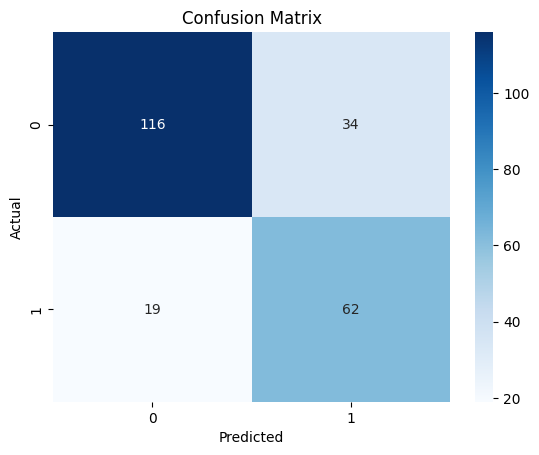

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
